# Прогнозирование метрик

## Задача №1

Команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-11-08 по 2023-11-14. 

Цель – оценить эффективность этого мероприятия.

Задачи:
1. Предположить, какие метрики должны были измениться во время флэшмоба и как. Предложить 5 метрик.
2. Проверить, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - описать, как именно изменилась метрика и насколько.
3. Сделать выводы, имел ли флэшмоб какие-то долгосрочные эффекты? 

In [1]:
#Импортируем библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np
from causalimpact import CausalImpact
import tensorflow_probability as tfp
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза

#Сразу зафиксируем переменную для учета тренда в CI
trend_component = tfp.sts.LocalLinearTrend() 

#подключаемся к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator',
'user':'student',
'password':'dpo_python_2020'
}

#Задаем размер графика
sns.set(rc={'figure.figsize':(15,10)})

2023-12-10 08:03:48.079165: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 08:03:48.177311: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 08:03:48.179114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 08:03:49.773084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


В качестве метрик, на основе которых мы будем анализировать активность пользователей используем:

1. Количество лайков на пользователя
2. Количество просмотров на пользователя
3. CTR
4. DAU
5. Количество действий пользователей суммарное.

Все метрики сгруппированны по дням. Используем данные за октябрь и ноябрь, что бы модель могла обучится качественней.

In [2]:
#Выгружаем нужные данные. 
q = """
SELECT toDate(time) day,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr,
    count(distinct user_id) DAU,
    count(user_id) user_actions
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-01' and '2023-11-30'
GROUP BY day
"""

df = ph.read_clickhouse(q, connection=connection)

In [3]:
# Возьмем дату за индекс, что бы было удобнее
df = df.set_index('day')

In [4]:
df

,likes,views,ctr,DAU,user_actions
day,,,,,
2023-10-01,23800,118996,0.200007,3721,142796
2023-10-02,34504,174454,0.197783,4617,208958
2023-10-03,33604,168419,0.199526,4728,202023
2023-10-04,37604,184971,0.203297,4890,222575
2023-10-05,46308,231423,0.200101,5878,277731
...,...,...,...,...,...
2023-11-26,132894,659099,0.201630,20061,791993
2023-11-27,120249,590392,0.203677,20400,710641
2023-11-28,139146,661020,0.210502,20198,800166


Исследуем первую метрику, лайки. Используем модель линейного тренда, который мы в целом наблюдали на дашбордах на протяжении этих месяцев.

Если флешмоб имел серьезное влияние на активность пользователей в долгосрочном периоде, то с момента окончания флешмоба мы должны заметить значительное превышение метрикой прогнозной величины на протяжении времени.

In [5]:
df_likes = df[['likes']]
Impact = CausalImpact(data = df_likes, #данные
                      pre_period = ['2023-10-01','2023-11-07'], #период до события
                      post_period = ['2023-11-15', '2023-11-30'], #период после события
                     model = trend_component) 

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


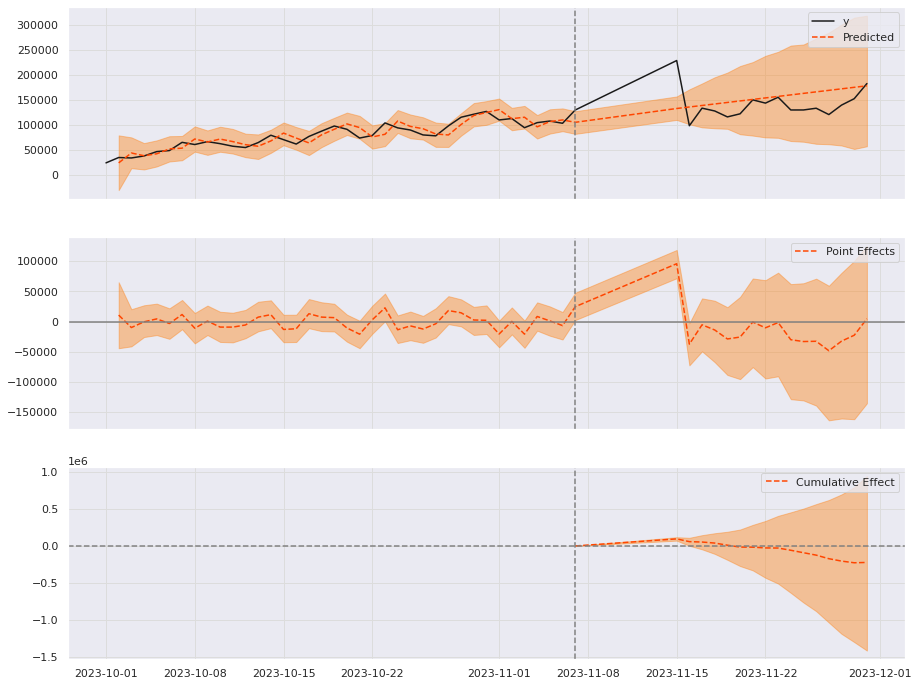

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    141043.38          2256694.0
Prediction (s.d.)         155002.72 (35028.16)2480043.5 (560450.54)
95% CI                    [90108.25, 227416.14][1441732.01, 3638658.21]

Absolute effect (s.d.)    -13959.34 (35028.16)-223349.5 (560450.54)
95% CI                    [-86372.76, 50935.12][-1381964.21, 814961.99]

Relative effect (s.d.)    -9.01% (22.6%)     -9.01% (22.6%)
95% CI                    [-55.72%, 32.86%]  [-55.72%, 32.86%]

Posterior tail-area probability p: 0.34
Posterior prob. of a causal effect: 65.73%

For more details run the command: print(impact.summary('report'))


In [6]:
Impact.plot(figsize=(15, 12))
print(Impact.summary())

В конечном счете мы видим, что лайки ожидаемо и очень значительно вырастают на период флешмоба, а затем находятся немного ниже прогнозной метрики. В данном сулчае, мы не можем сделать вывода о наличии долгосрочного эффекта (-9.11%).

Следующая метрика - просмотры. Логика та же.

In [7]:
df_views = df[['views']]
Impact = CausalImpact(data = df_views, #данные
                      pre_period = ['2023-10-01','2023-11-07'], #период до события
                      post_period = ['2023-11-15', '2023-11-30'], #период после события
                     model = trend_component) 

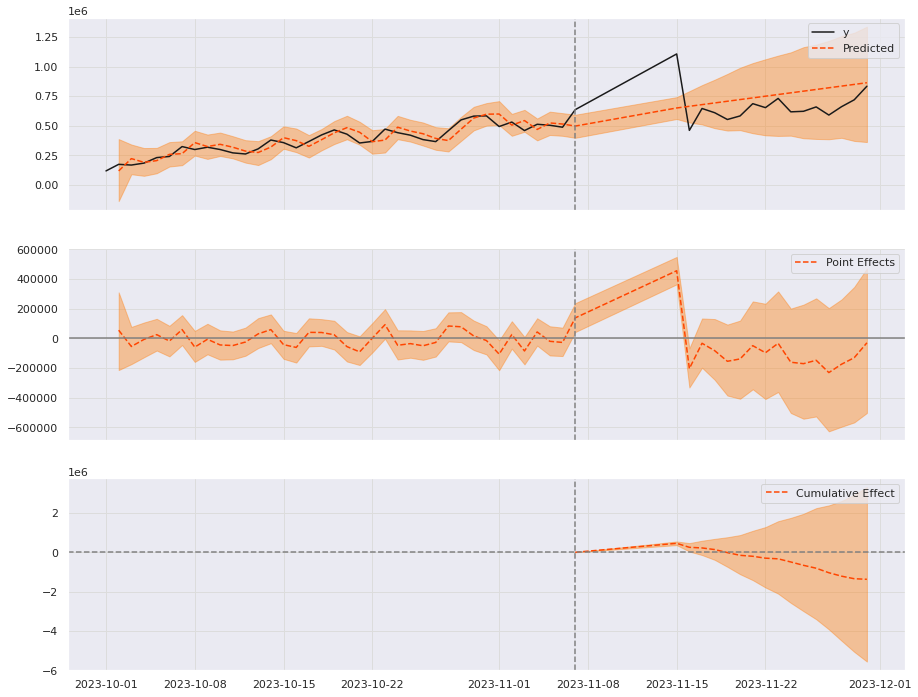

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    670773.38          10732374.0
Prediction (s.d.)         756612.38 (141467.01)12105798.0 (2263472.11)
95% CI                    [486261.55, 1040802.14][7780184.76, 16652834.25]

Absolute effect (s.d.)    -85839.0 (141467.01)-1373424.0 (2263472.11)
95% CI                    [-370028.77, 184511.83][-5920460.25, 2952189.24]

Relative effect (s.d.)    -11.35% (18.7%)    -11.35% (18.7%)
95% CI                    [-48.91%, 24.39%]  [-48.91%, 24.39%]

Posterior tail-area probability p: 0.25
Posterior prob. of a causal effect: 75.22%

For more details run the command: print(impact.summary('report'))


In [8]:
Impact.plot(figsize=(15, 12))
print(Impact.summary())

И снова мы наблюдаем, что просмотры ожидаемо и очень значительно вырастают на период флешмоба, а затем находятся немного ниже прогнозной метрики . В данном сулчае, мы не можем сделать вывода о наличии долгосрочного эффекта. (-14.3%)

На очереди СTR.

In [9]:
df_ctr = df[['ctr']]
Impact = CausalImpact(data = df_ctr, #данные
                      pre_period = ['2023-10-01','2023-11-07'], #период до события
                      post_period = ['2023-11-15', '2023-11-30'], #период после события
                     model = trend_component) 

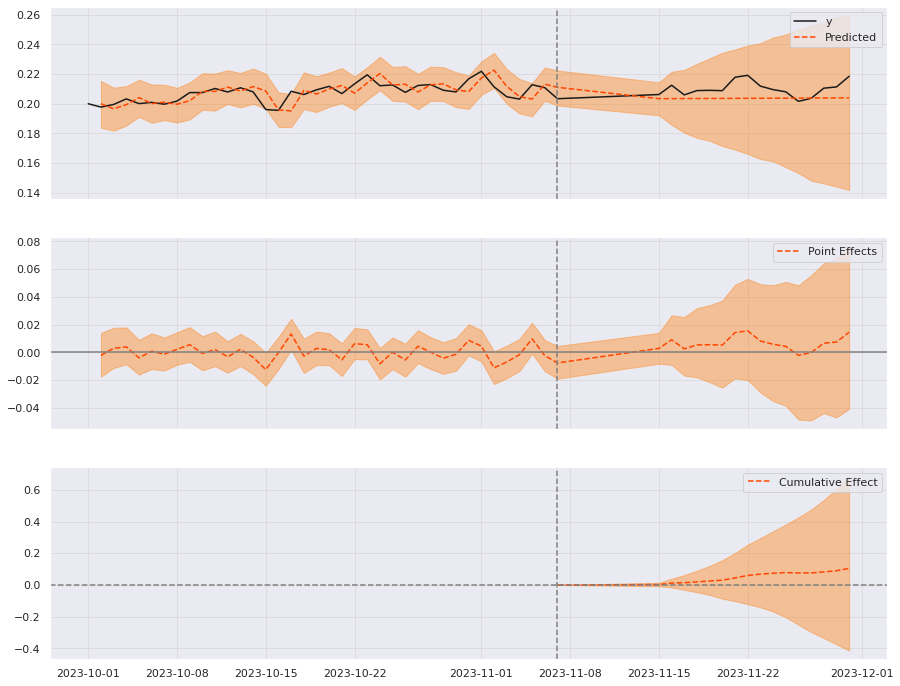

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               3.36
Prediction (s.d.)         0.2 (0.02)         3.26 (0.26)
95% CI                    [0.17, 0.24]       [2.77, 3.79]

Absolute effect (s.d.)    0.01 (0.02)        0.1 (0.26)
95% CI                    [-0.03, 0.04]      [-0.43, 0.59]

Relative effect (s.d.)    3.2% (7.98%)       3.2% (7.98%)
95% CI                    [-13.21%, 18.07%]  [-13.21%, 18.07%]

Posterior tail-area probability p: 0.35
Posterior prob. of a causal effect: 65.43%

For more details run the command: print(impact.summary('report'))


In [10]:
Impact.plot(figsize=(15, 12))
print(Impact.summary())

В отличии от прошлых метрик ctr  показал рост от прогнозных показателей +4%.

DAU - настал твой черед.

In [11]:
df_DAU = df[['DAU']]
Impact = CausalImpact(data = df_DAU, #данные
                      pre_period = ['2023-10-01','2023-11-07'], #период до события
                      post_period = ['2023-11-15', '2023-11-30'], #период после события
                     model = trend_component) 

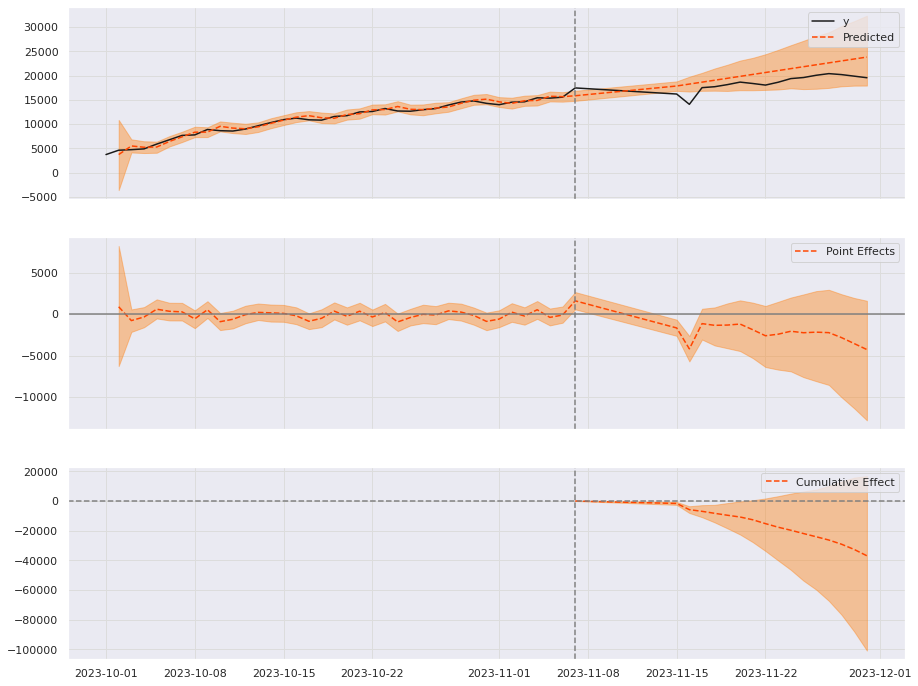

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    18522.06           296353.0
Prediction (s.d.)         20830.7 (1706.96)  333291.16 (27311.42)
95% CI                    [17597.94, 24289.12][281567.03, 388625.85]

Absolute effect (s.d.)    -2308.63 (1706.96) -36938.16 (27311.42)
95% CI                    [-5767.05, 924.12] [-92272.85, 14785.97]

Relative effect (s.d.)    -11.08% (8.19%)    -11.08% (8.19%)
95% CI                    [-27.69%, 4.44%]   [-27.69%, 4.44%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 92.41%

For more details run the command: print(impact.summary('report'))


In [12]:
Impact.plot(figsize=(15, 12))
print(Impact.summary())

DAU повторил судьбу первых метрик, но с некоторыми особенностями , на период флешмоба всплеска уникальной аудитории не наблюдается, а затем показатели находятся немного ниже прогнозной метрики . В данном сулчае, мы не можем сделать вывода о наличии долгосрочного эффекта(-12.21%). 

Количество действий пользователей на сайте в целом, будет коррелировать с первыми двумя метриками, возьмем ее больше для надежности.

In [13]:
df_user_actions = df[['user_actions']]
Impact = CausalImpact(data = df_user_actions, #данные
                      pre_period = ['2023-10-01','2023-11-07'], #период до события
                      post_period = ['2023-11-15', '2023-11-30'] , #период после события
                     model = trend_component) 

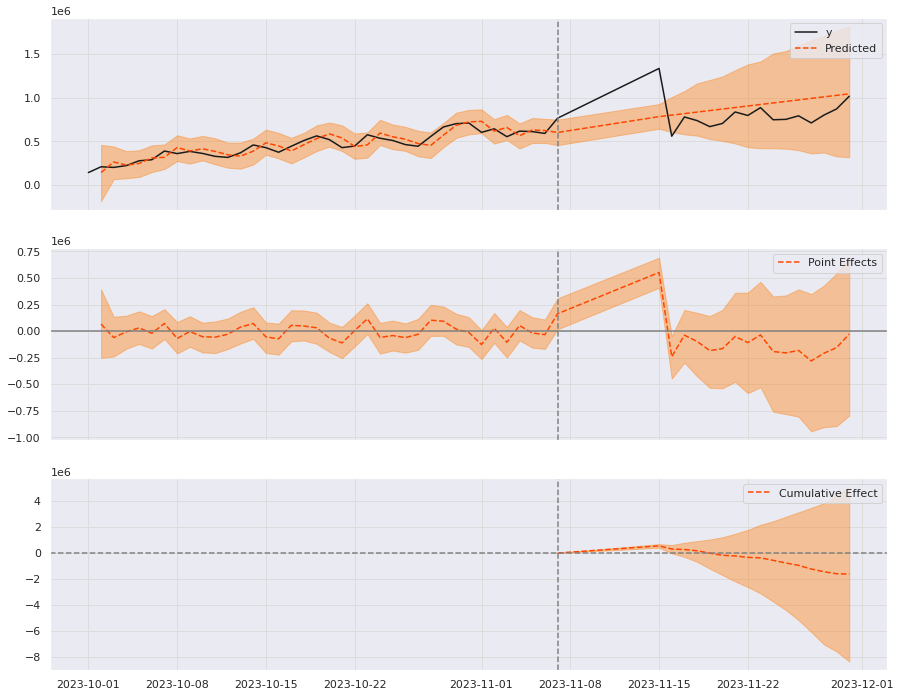

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    811816.75          12989068.0
Prediction (s.d.)         913131.12 (216666.03)14610098.0 (3466656.47)
95% CI                    [476540.48, 1325855.88][7624647.65, 21213694.15]

Absolute effect (s.d.)    -101314.38 (216666.03)-1621030.0 (3466656.47)
95% CI                    [-514039.13, 335276.27][-8224626.15, 5364420.35]

Relative effect (s.d.)    -11.1% (23.73%)    -11.1% (23.73%)
95% CI                    [-56.29%, 36.72%]  [-56.29%, 36.72%]

Posterior tail-area probability p: 0.29
Posterior prob. of a causal effect: 70.63%

For more details run the command: print(impact.summary('report'))


In [14]:
Impact.plot(figsize=(15, 12))
print(Impact.summary())

Выводы аналогичны, показатели меньше прогнозных (-12.98%). 

### Вывод

1. На основании полученных результатов нельзя сделать вывод, о наличии долгосрочного эффекта флешмоба на рост активости аудитории приложения в ленте новостей. 
2. Метрика CTR единственная, которая продемонстрировала рост выше прогнозных величин, но причины ее роста нужно рассматривать отдельно.


## Задача №2

Цель - спрогнозировать, как изменится активность пользователей в течение ближайшего месяца.

Задачи:
1. Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?

2. Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
3. Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.

Самая простая и понятная метрика, которая может характеризовать нагрузку на сервера - это количество действий, совершаемых пользователями.
Выгрузим данные с разбивкой по дням из ленты новостей и из сообщений.

In [15]:
q = """
select day, t1.user_actions1 + t2.user_actions2  user_actions 
from 
(SELECT toDate(time) day,
       count(user_id) user_actions1
FROM simulator_20231113.feed_actions 
GROUP BY day
HAVING day < '2023-12-10') t1
join (SELECT toDate(time) day,
       count(user_id) user_actions2
FROM simulator_20231113.message_actions
GROUP BY day
HAVING day < '2023-12-10') t2 on t1.day=t2.day
"""

user_activity = ph.read_clickhouse(q, connection=connection)

Попробуем выявить сезонность в данных для рассчета модели

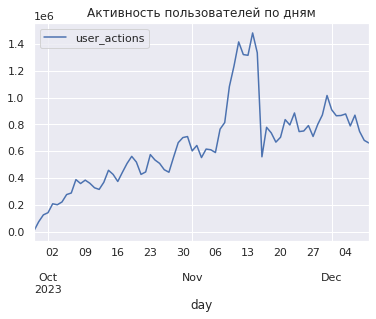

In [32]:
user_activity.plot(x='day', y='user_actions', title='Активность пользователей по дням');

Наиболее очевидно недельное колебание данных, определим сезонность равную 7 дням.

Сразу оговоримся, что данных у нас не то чтобы и мало, но и не сказать что их хватит для того чтобы строить максимально точную предсказательную модель.

Во-первых, из-за небольших временных горизонтов мы берем данные с самого начала работы приложения. Пускай по поведению они немного отличаются, но в целом похожи на данные, которые идут после (до 09.10 и после соответственно).

Во-вторых, мы имеем аномальный всплеск активности пользователей, вызванный проводимым флешмобом, но исключать его не будем, хоть значения и больше, но в целом характер распределения данных схожий.

В рамках поставленного срока данных должно хватить для прогнозирования.

Для моделей использованы алгоритм оценки MAP и Markov Chain Monte Carlo.  Дополнительные регрессоры не применяются.


Построим первую модель

2023-12-10 08:45:19 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

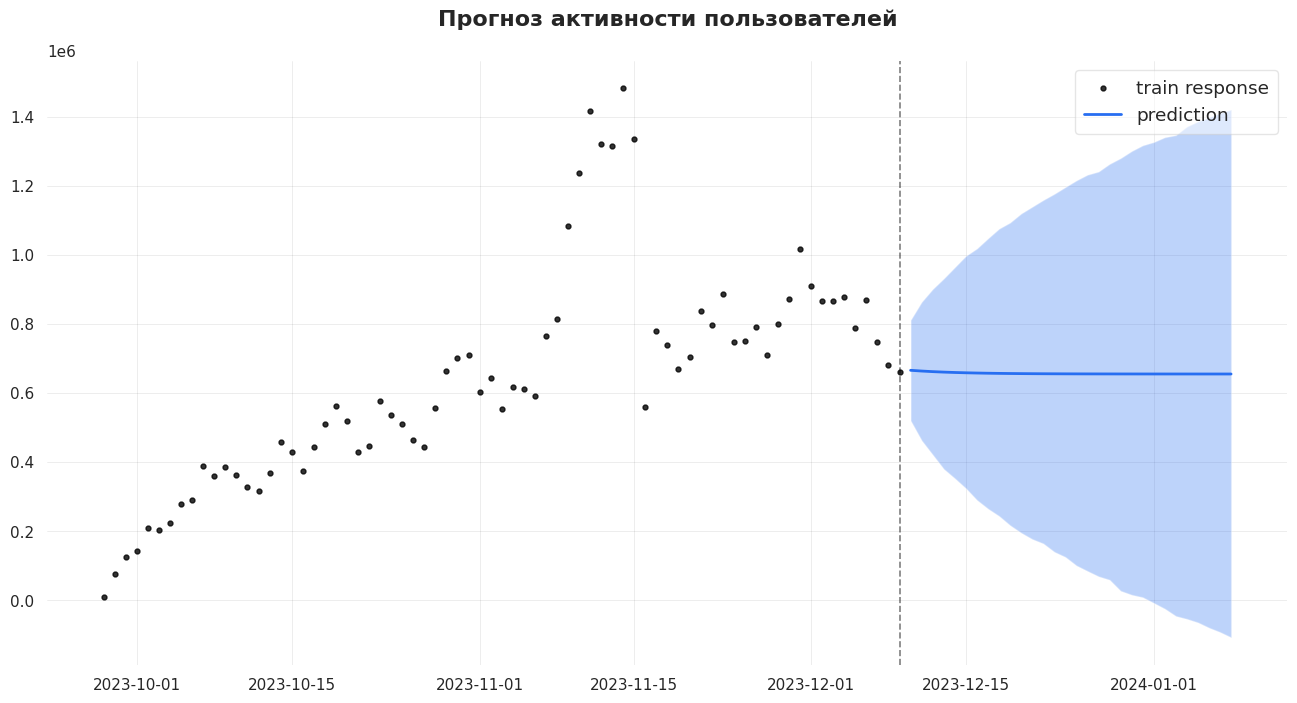

In [33]:
dlt1 = DLT(response_col="user_actions", #название колонки с метрикой
          date_col="day", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности 
          estimator="stan-map", #алгоритм оценки
         n_bootstrap_draws=10000) #количество сэмплов бутстрапа для доверительного интервала

dlt1.fit(user_activity)

future_df1 = dlt1.make_future_df(periods=30) 

predicted_df1 = dlt1.predict(df=future_df1)

_ = plot_predicted_data(user_activity, #изначальные данные
                        predicted_df1, #датафрейм с предсказаниями
                        "day", #колонка со временем
                        'user_actions', #колонка со значениями временного ряда
                        title='Прогноз активности пользователей') #заголовок рисунка

In [34]:
dlt2 = DLT(response_col="user_actions", #название колонки с метрикой
          date_col="day", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности 
          estimator="stan-mcmc", #алгоритм оценки
          num_warmup=20000,
         num_sample=10000) #количество сэмплов бутстрапа для доверительного интервала

In [35]:
dlt2.fit(user_activity)

2023-12-10 08:45:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [36]:
#Определяем горизонт планирования - по запросу в задании он равен 30 дням
future_df2 = dlt2.make_future_df(periods=30) 

In [37]:
predicted_df2 = dlt2.predict(df=future_df2)
display(predicted_df2)

,day,prediction_5,prediction,prediction_95
0,2023-12-10,507580.329264,6.651423e+05,8.241272e+05
1,2023-12-11,444505.773503,6.690259e+05,8.910724e+05
2,2023-12-12,398748.468903,6.853867e+05,9.559483e+05
3,2023-12-13,356401.734345,6.857446e+05,1.009147e+06
4,2023-12-14,310931.322407,6.903666e+05,1.053081e+06
5,2023-12-15,287720.022027,7.094898e+05,1.118655e+06
6,2023-12-16,263472.838376,7.283136e+05,1.184777e+06
7,2023-12-17,237273.604425,7.391828e+05,1.235147e+06
8,2023-12-18,214715.173888,7.524002e+05,1.290417e+06
9,2023-12-19,198328.694307,7.725061e+05,1.350471e+06


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

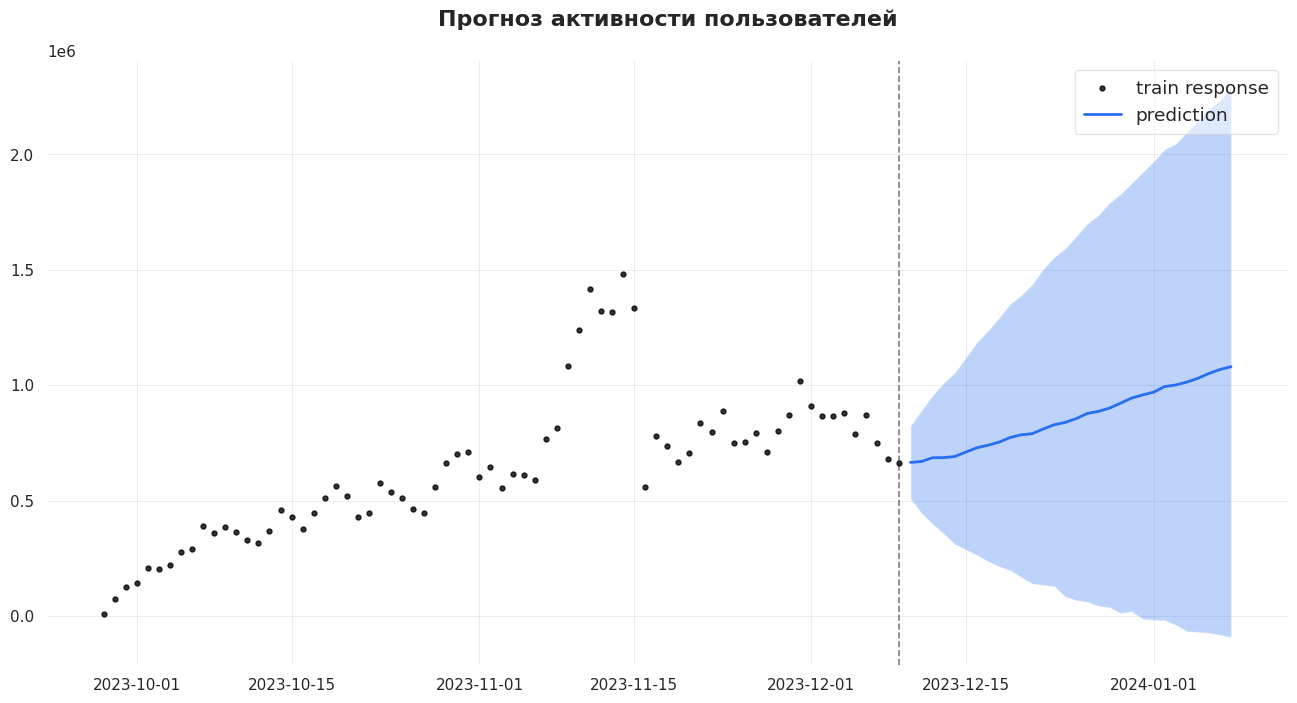

In [38]:
_ = plot_predicted_data(user_activity, #изначальные данные
                        predicted_df2, #датафрейм с предсказаниями
                        "day", #колонка со временем
                        'user_actions', #колонка со значениями временного ряда
                        title='Прогноз активности пользователей') #заголовок рисунка

Модель МСМС предоставила следующие данные, что спустя 30 дней количество действий в день может достигнуть ~1,1 миллиона действий пользователей в день. 

Доверяй, но проверяй, приступаем к валидации модели.

Говоря о бэктесте, временной ряд не сильно протяженный, что может затруднить валидацию как первой, так и второй модели.

In [39]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга

In [40]:
bt1 = BackTester(
    model=dlt1, #наша моделька
    df=user_activity, #датафрейм для обучения
    min_train_len=10, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=1, #на сколько происходит прирост тренировочных данных
    forecast_len=30, #горизонт прогнозирования
    window_type='expanding' #тип окошка
)

bt1.fit_predict()

In [41]:

bt2 = BackTester(
    model=dlt2, #наша моделька
    df=user_activity, #датафрейм для обучения
    min_train_len=10, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=1, #на сколько происходит прирост тренировочных данных
    forecast_len=30, #горизонт прогнозирования
    window_type='expanding' #тип окошка
)

In [42]:
bt2.fit_predict()

2023-12-10 08:46:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:46:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:46:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:46:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:46:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:47:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:47:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:47:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:47:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:47:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:47:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:48:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:48:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:48:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:48:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:48:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:49:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:49:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:49:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:49:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:50:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:50:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:50:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:50:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:51:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:51:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:51:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:52:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:52:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:52:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:52:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:53:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-12-10 08:53:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 5000 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Посмотрим метрики, оценивающие наши модели:

In [43]:
bt1.score()

,metric_name,metric_values,is_training_metric
0,smape,2.908120e-01,False
1,wmape,3.141462e-01,False
2,mape,3.102679e-01,False
3,mse,1.039089e+11,False
4,mae,2.439488e+05,False
5,rmsse,1.789227e+00,False


In [44]:
bt2.score()

,metric_name,metric_values,is_training_metric
0,smape,3.027849e-01,False
1,wmape,3.415693e-01,False
2,mape,3.505920e-01,False
3,mse,1.204165e+11,False
4,mae,2.652440e+05,False
5,rmsse,1.926115e+00,False


Довольно интересный момент, что метрики которые считаются в долях более качественно оценивают модель, нежели метрики, которые представляют из себя взаимодействие с оценкой ошибки в абсолютном выражении. 

Но при всем  при этом метрики оценивают первую модель лучше, чем вторую.

Так как мы проверяем модель использующую МСМС нам важно оценить сходимость цепей, сходятся ли они возле одного значения

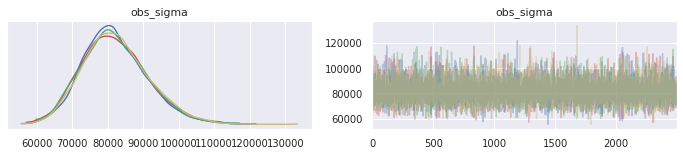

In [45]:
import arviz as az

params = dlt2.get_posterior_samples(permute=False, relabel=True) #достаём информацию о параметрах

az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma");

И здесь мы можем увидеть, что да, цепи сходятся. В целом, по совокупности фактов можно признать что модели валидны.

### Вывод
1. Модель дает прогноз о возможном росте нагрузки на серверы в наиболее вероятном диапазоне 0,7-1.1 миллиона событий в день
2. Стоит отметить, что линии прогноза, которые дают модели, идут под немного иными углами относительно логарифмической линии тренда в данных, что тоже стоит учесть при интерпретации прогноза. 
3. Несмотря на то, что модель МСМС считается более точной, метрики оценивают ее хуже, чем МАР модель.

P.S. Это был вообще мой первый опыт работы с ML, надеюсь получилось хотя бы нелохо. Очень интересно получить фидбэк, особенно что касается  валидации интерпритации модели. В целом Орбит показался удобней в использовании в сравнении с Казуал, документация более собранная и целостная, а это большая часть успеха в освоении инструмента.